# Preprocessing and analysis of EEG data

In [ ]:
# Activate virtual envoriment:

import os
path='/work/807122' # Remember to change kernel to virt_env!!!
os.chdir(path)
!./activate.sh

In [ ]:
### Check that im are in the right environment

import sys
print(sys.executable)
import nilearn

In [4]:
# importing modules
import os
import pip
import numpy as np
import mne
import pickle
import itertools

import matplotlib.pyplot as plt
import importlib
importlib.reload(plt)

import pylab, seaborn as sns
from scipy.stats import ttest_rel, sem

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,Vectorizer, CSP)
from scipy import stats
from scipy.stats import binomtest
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 1. Load data

In [ ]:
# Load data in with a hierarchical structure: each participants and respectively, their three sessions

#data_dir = '/work/823001/ds003626-download/derivatives/'
data_dir = '/work/data/ds003626-download/derivatives/'

# Empty folder 
all_data = []

# Listing all folders in data_dir that start with "sub-"
participants = [folder for folder in os.listdir(data_dir) if folder.startswith('sub-')]

# Define a list of modality labels (i.e., trial class)
modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']

# Create lists, that will be filled up with all participants' data
participants_pronounced = []
participants_inner = []
participants_visualized = []

# Loop through each participant's data
for participant in participants:
    participant_dir = os.path.join(data_dir, participant)
    
    # Create empty lists to store participant and session data (these resets for each participants)
    session_pronounced = []
    session_inner = []
    session_visualized = []
    
    # Loop through all sessions for each participant in part_dir
    for session_num in range(1, 4):  #session "ses-01", "ses-02", and "ses-03"
        session_dir = os.path.join(participant_dir, f'ses-0{session_num}')
        
        # [] = list, {} = dictonary 
        event_dat = []
        event_data = {}
        event_data_session = {}
        
        # Create dictionaries for the three conditions
        pronounced_con = {} # column 2 == 0
        inner_con = {} # column 2 == 1
        visualized_con = {} # column 2 == 2
        
        # .dat file path
        dat_file_path = os.path.join(session_dir, f'{participant}_ses-0{session_num}_events.dat')
    
       # if os.path.exists(dat_file_path):
        ## i have commented this line of code out, as I want to recieve an error if a event.dat file is missing
        with open(dat_file_path, "rb") as file: # "rb" = read in binary format
            event_dat = pickle.load(file)
       
        # loop over the elements of the modality_label list (match labels and events.dat)
        # filter the event_dat based on the values of column 2 (class/modality)
        for l, label in enumerate(modality_label):
            event_data[label] = event_dat[event_dat[:,1]==l,:] 
        
        # now event_data contains 4 arrays (one for each of the modalities)
 
        # EEG .fif file path
        eeg_file_path = os.path.join(session_dir, f'{participant}_ses-0{session_num}_eeg-epo.fif')
        
        #if os.path.exists(eeg_file_path):
        ## same goes for the eeg.fif files
        epochs = mne.read_epochs(eeg_file_path, preload=True)
        
        # Check for epochs .fif and events .dat file correspondence (they will be matched on timestamps)
        # Correspondence = 0
        if not sum(epochs.events[:,0]-event_dat[:,0])==0:
            print("MISMATCH IN EPOCHS/DAT FILE TIMESTAMPS! {}".format(session_dir))
            break # Naturally, we want to stop the loop, if an error / mismatch occurs 
        
        # Specify channel location (EEG data acquired used BioSemi128)
        montage = mne.channels.make_standard_montage('biosemi128')
        epochs.set_montage(montage, verbose=False)
        
        # Loop over each condition (0, 1, 2) in modaility_label in data-file
        for label in modality_label:
            pronounced_con[label] = epochs[label][event_data[label][:, 2] == 0]
            inner_con[label] = epochs[label][event_data[label][:, 2] == 1]
            visualized_con[label] = epochs[label][event_data[label][:, 2] == 2]
        
            # Same sanity-check for the conditions and modalities
            if not (sum(pronounced_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 0, 0])==0 or 
                    sum(inner_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 1, 0])==0 or
                    sum(visualized_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 2, 0])==0):
                print("MISMATCH IN LABEL EPOCHS / LABEL DAT FILE TIMESTAMPS! {}: {}".format(session_dir, label))
                break
        
        session_pronounced.append(pronounced_con)
        session_inner.append(inner_con)
        session_visualized.append(visualized_con)
     
    # Empty dictionaries to store concatenated data for each condition
    concatenated_pronounced = {}
    concatenated_inner = {}
    concatenated_visualized = {}
    
    # Loop through the modality labels
    for label in modality_label:
        # Concatenate the sessions for the pronounced con
        pronounced_sessions = [sessions[label] for sessions in session_pronounced]
        concatenated_pronounced[label] = mne.concatenate_epochs(pronounced_sessions)

        # Concatenate the sessions for the inner con
        inner_sessions = [sessions[label] for sessions in session_inner]
        concatenated_inner[label] = mne.concatenate_epochs(inner_sessions)

        # Concatenate the sessions for the visualized 
        visualized_sessions = [sessions[label] for sessions in session_visualized]
        concatenated_visualized[label] = mne.concatenate_epochs(visualized_sessions)
    
    # Combine back into an epochs object with the four directions as conditions
    # ... now I will be able to analyze all 4 directions/labels over all 3 sessions for inner speech in the same object
    conc_pronounced = mne.concatenate_epochs([concatenated_pronounced[label] for label in modality_label])
    conc_inner = mne.concatenate_epochs([concatenated_inner[label] for label in modality_label])
    conc_visualized = mne.concatenate_epochs([concatenated_visualized[label] for label in modality_label])
    
    # Print length of one of the conditions, here concatenated_pronounced, to check if it's empty
    print(f"Participant {participant}: Number of sessions with EEG data: {len(concatenated_pronounced)}")
    
    # Append the EEG data to the three 'conditions' list
    participants_pronounced.append(conc_pronounced)  
    participants_inner.append(conc_inner)  
    participants_visualized.append(conc_visualized)  
        
    # Append the epochs to the all_data list
    #all_data.append(epochs)
            
# Print length of all_data to check if it's empty 
print(f"Total number of participants with EEG data: {len(participants_pronounced)}")


In [6]:
participants_pronounced[1].info

<Info | 11 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: True
 dig: 131 items (3 Cardinal, 128 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2019-08-20 13:19:39 UTC
 meas_id: 4 items (dict)
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

# 2. Visual inspection


Using matplotlib as 2D backend.


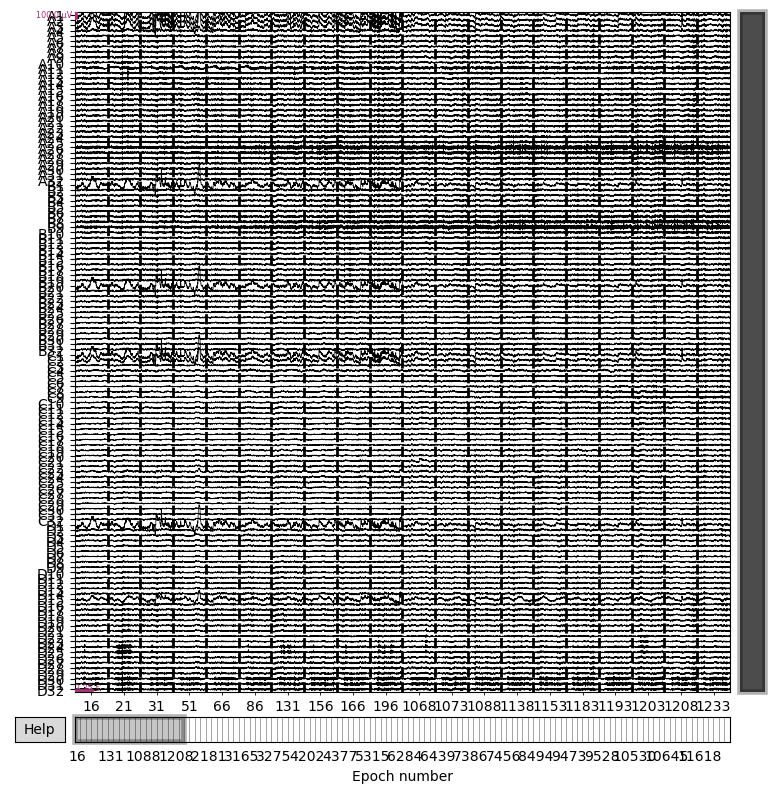

In [7]:
#participants_pronounced[0].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[1].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[2].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[3].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[4].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[5].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[6].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[7].plot(n_channels=128, scalings=dict(eeg=50e-6));
#participants_pronounced[8].plot(n_channels=128, scalings=dict(eeg=50e-6));
participants_pronounced[9].plot(n_channels=128, scalings=dict(eeg=50e-6));

## 2.1 Filtering

The data has already been preprocessed including highpass (removing low frequencies) and lowpass (removing high frequencies) filtered, but there still seems to be some "unstable/outliers".

Therefore, an **additional lowpass filter** will be applied.
The lowpass filter will be set to 40 Hz, meaning all frequencies lower than this through will pass through (which includes removing muscle artefacts (since these are higher than 40 Hz) and noise from power cords).

The highpass filter is already set to 0.5 Hz, which minimises slow drifts in the data (e.g. scalp potentials). This will not be lowered.

In [ ]:
low_pass = 40  # Let all frequencies lower than 40 Hz pass through

# Loop through all participants' conditions and apply low-pass filter of 40 Hz
for i in range(0, 10):  # Beacuse I have 10 participants        
    participants_pronounced[i] = participants_pronounced[i].filter(None, low_pass)

for i in range(0, 10):      
    participants_inner[i] = participants_inner[i].filter(None, low_pass)

for i in range(0, 10):      
    participants_visualized[i] = participants_visualized[i].filter(None, low_pass)

Now we can inspect the differet participants once again:

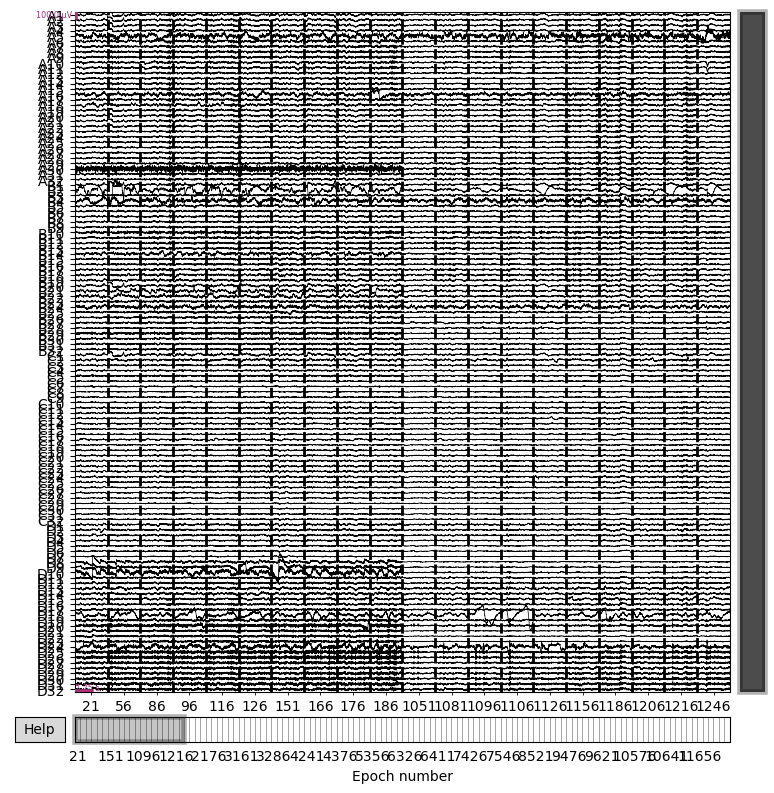

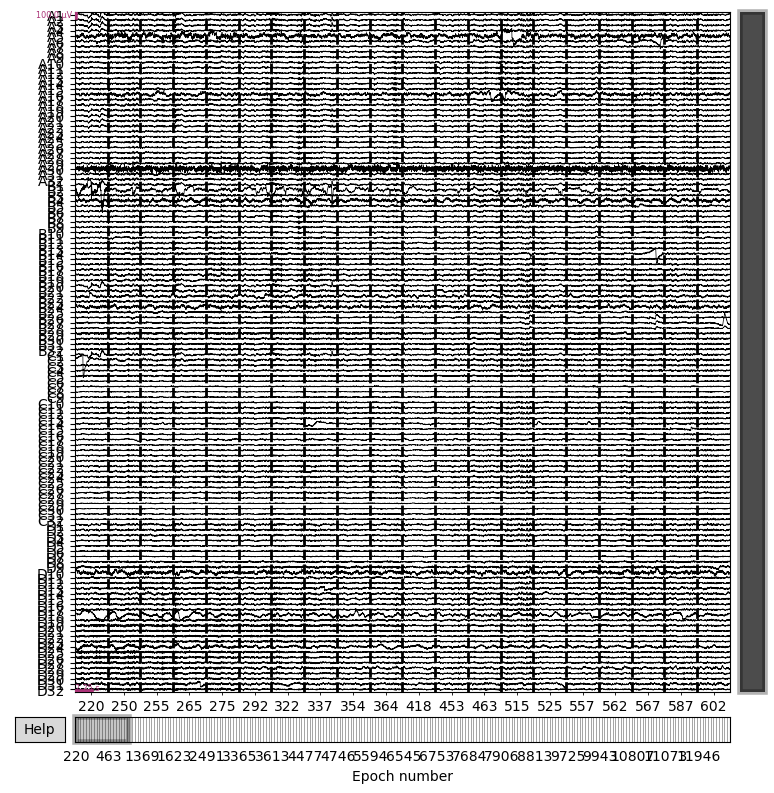

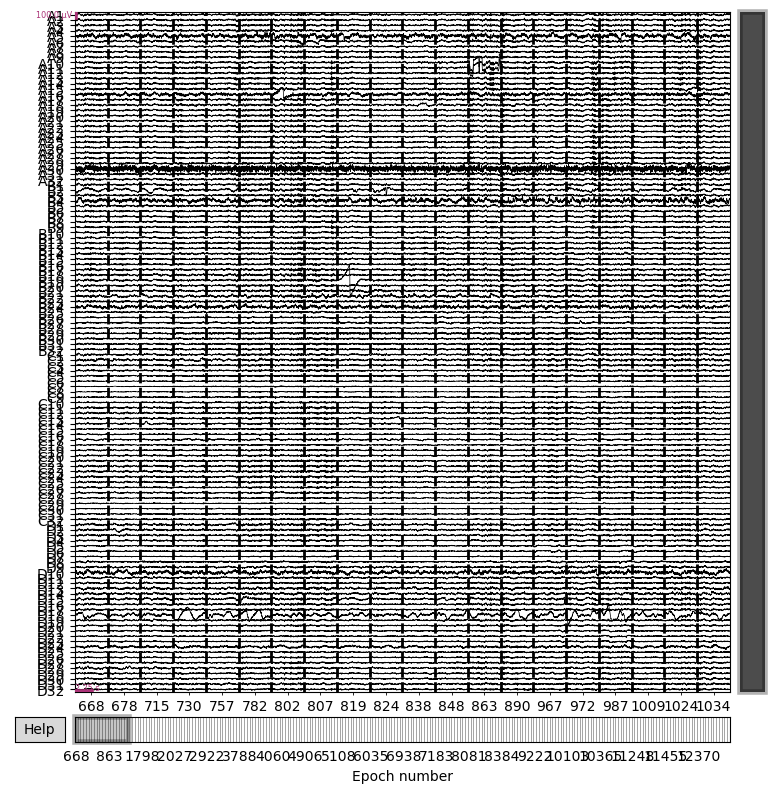

In [9]:
participants_pronounced[1].plot(n_channels=128, scalings=dict(eeg=50e-6));
participants_inner[1].plot(n_channels=128, scalings=dict(eeg=50e-6));
participants_visualized[1].plot(n_channels=128, scalings=dict(eeg=50e-6));

As some of the channels still looks a bit messy, I have selected the specific channels.

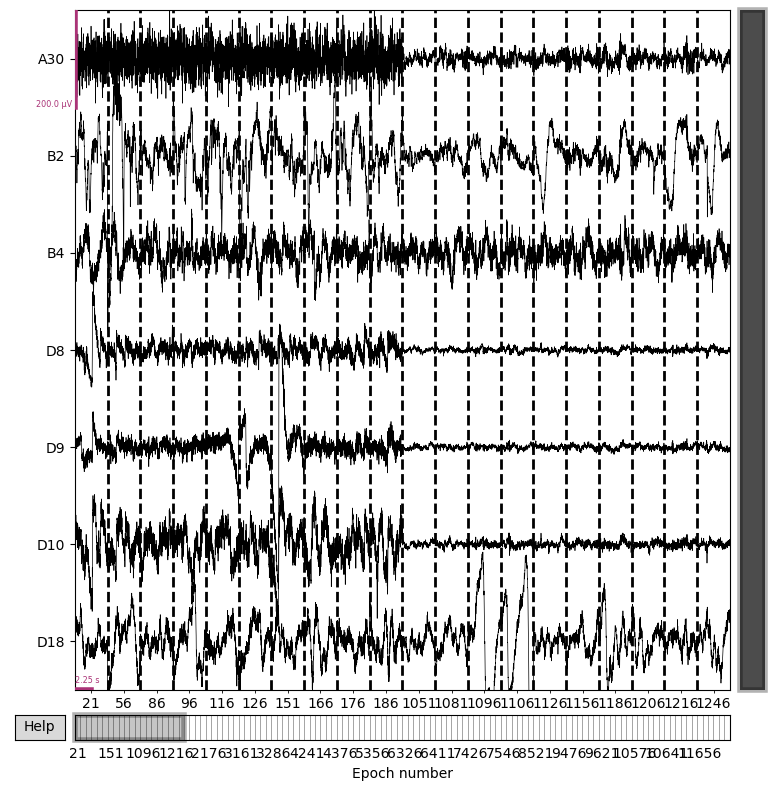

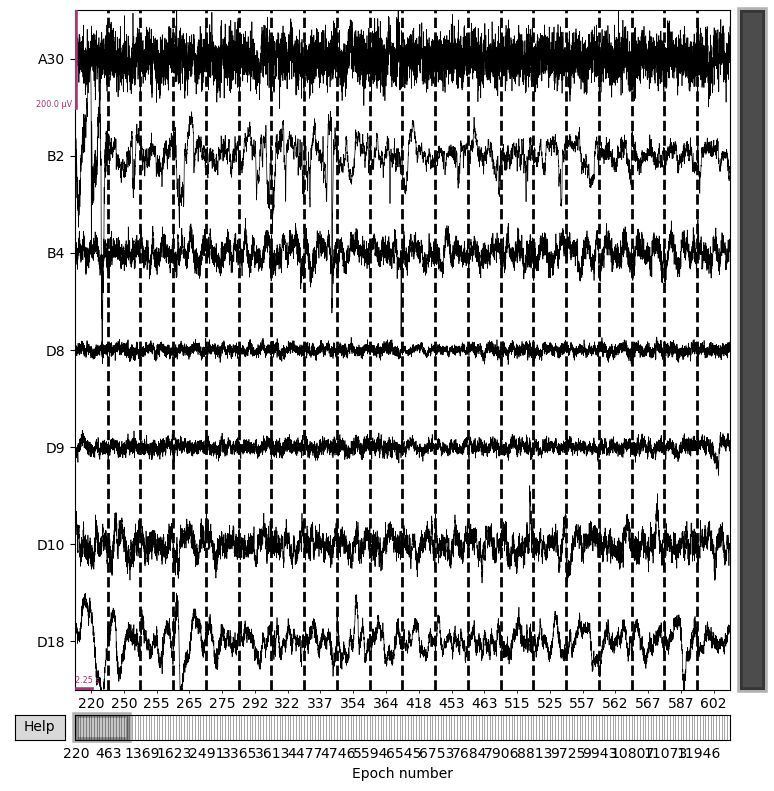

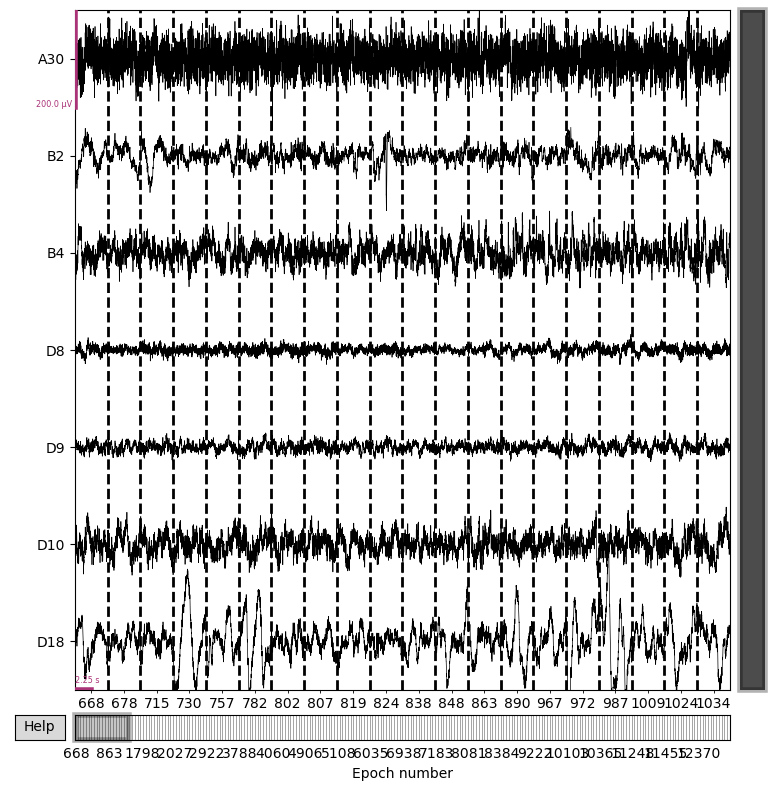

In [10]:
participants_pronounced[1].plot(picks=['A30','B2', 'B4','D8', 'D9', 'D10','D18'], scalings=dict(eeg=100e-6));
participants_inner[1].plot(picks=['A30','B2', 'B4','D8', 'D9', 'D10','D18'], scalings=dict(eeg=100e-6));
participants_visualized[1].plot(picks=['A30','B2', 'B4','D8', 'D9', 'D10','D18'], scalings=dict(eeg=100e-6));

## 2.2 Power spectral density plots:

Here I plot frequencies below 50 Hz, as the data are low-pass filtered at 40 Hz

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


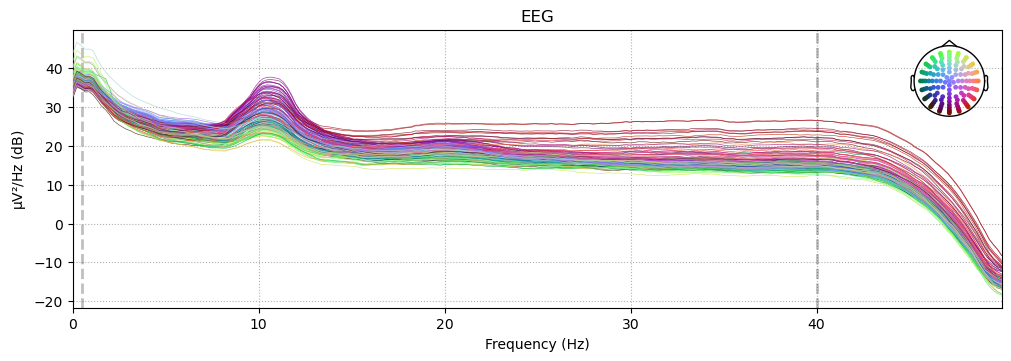

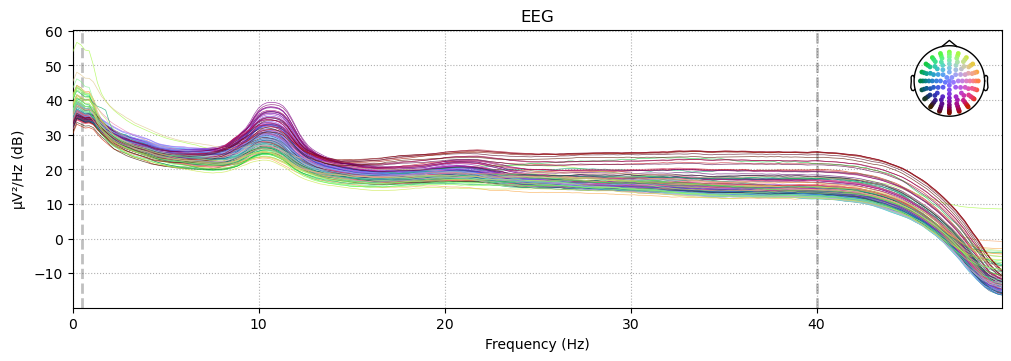

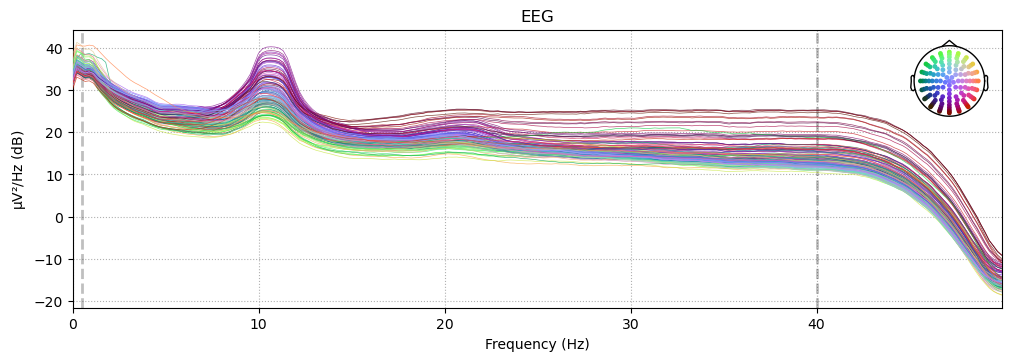

In [11]:
participants_pronounced[0].compute_psd(fmax=50).plot(picks="data", exclude="bads"); #participant 1
participants_inner[0].compute_psd(fmax=50).plot(picks="data", exclude="bads"); 
participants_visualized[0].compute_psd(fmax=50).plot(picks="data", exclude="bads"); 

# 3. Signal processing
## 3.1 Removal of bad channels + Interpolate of bad channels + Reject criteria

Since there is still some noise in the signal, a reject criteria will be applied. Any epoch where peak-to-peak signal amplitude is beyond X µV will be removed. Normally, the rejection criteria is set to 150 µV, but since too much signal are rejected, the criterion will be set up to 200 µV. 

Some channels are marked as bad, as they appear to be the source of noice, while keeping the amount of rejected epochs under ~5%.

This procedure is to make sure, that all eyeblinks etc. are removed.

In [12]:
# The following channels will be removed, as they caused too many epochs to be rejected:

participants_pronounced[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5', 'D20', 'B24'] 
participants_inner[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5', 'D14', 'A30'] 
participants_visualized[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5'] 

participants_pronounced[2].info['bads'] = ['A25', 'A27']
participants_inner[2].info['bads'] = ['A25', 'A27']
participants_visualized[2].info['bads'] = ['A25', 'A27']

participants_pronounced[4].info['bads'] =['B23', 'B24']
participants_visualized[4].info['bads'] =['B26']

participants_pronounced[5].info['bads'] =['D6', 'D8', 'D9', 'D10']
participants_inner[5].info['bads'] =['D6', 'D8', 'D9', 'D10']
participants_visualized[5].info['bads'] =['D6', 'D8', 'D9', 'D10']

participants_pronounced[9].info['bads'] = ['D1', 'C1', 'B20', 'A1', 'A2', 'A3', 'B1', 'C2']
participants_inner[9].info['bads'] = ['D1', 'C1', 'B20', 'A1', 'A2', 'A3', 'B1', 'C2']


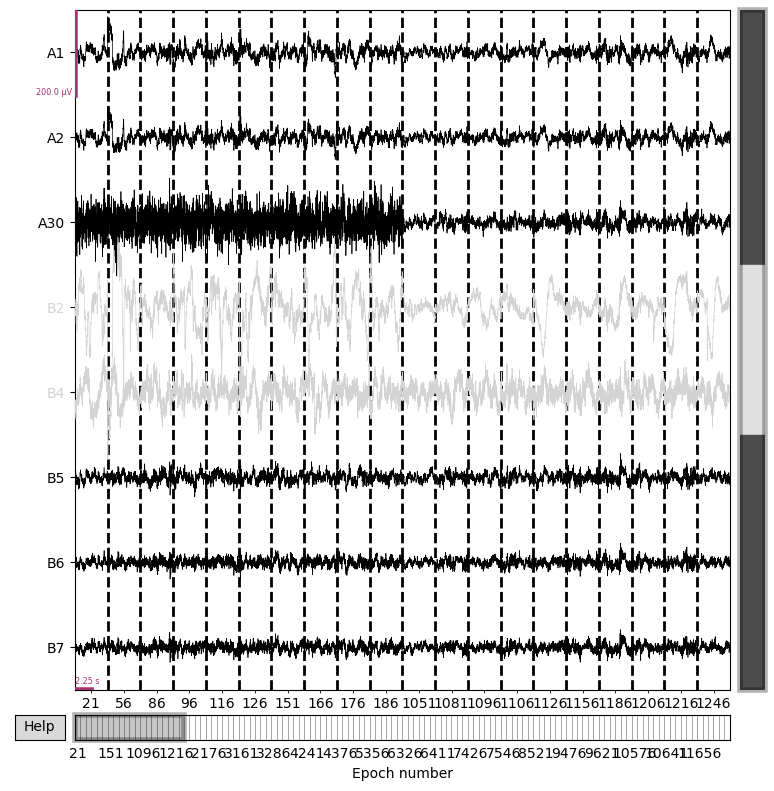

In [13]:
# Now, when we plot the data of the participant, the channels marked as bad  are plotted in a light gray color behind the other channels
# which makes it easy to distinguish them from “good” channels

participants_pronounced[1].plot(picks=['A30','B2', 'B4','B5', 'B6', 'B7', 'A1', 'A2'], scalings=dict(eeg=100e-6));

In [ ]:
# Interpolate bad channels
# Before doing classification, it is important, that my data maintain identical dimensionalities for all subjects
# As the same channels are not bad for all subjects, I will reconstruct bad channels by interpolating its signal
# based on the signals of the good sensors around them

for sub in participants_pronounced:
    sub.copy().interpolate_bads(reset_bads=False)

for sub in participants_inner:
    sub.copy().interpolate_bads(reset_bads=False)

for sub in participants_visualized:
    sub.copy().interpolate_bads(reset_bads=False)

In [ ]:
# Rejecting EEG epocs above 200 microvolts.
reject_criteria = dict(eeg=200e-6)

# Loop through the list of EpochsArray objects for each participant in each condtion
for sub in participants_pronounced:
    sub.drop_bad(reject=reject_criteria)
    
for sub in participants_inner:
    sub.drop_bad(reject=reject_criteria)

for sub in participants_visualized:
    sub.drop_bad(reject=reject_criteria)

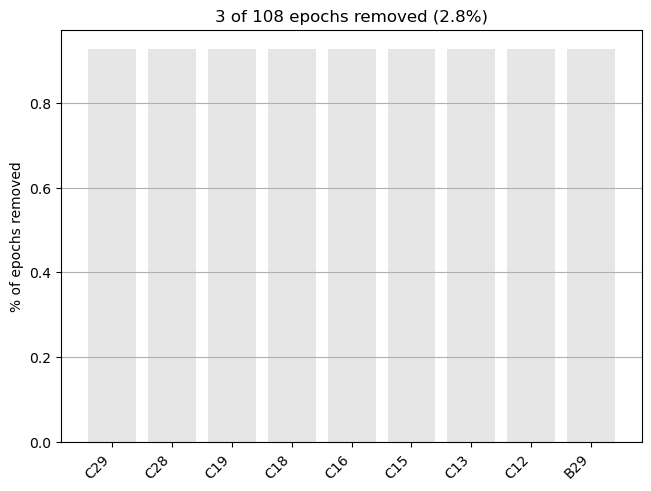

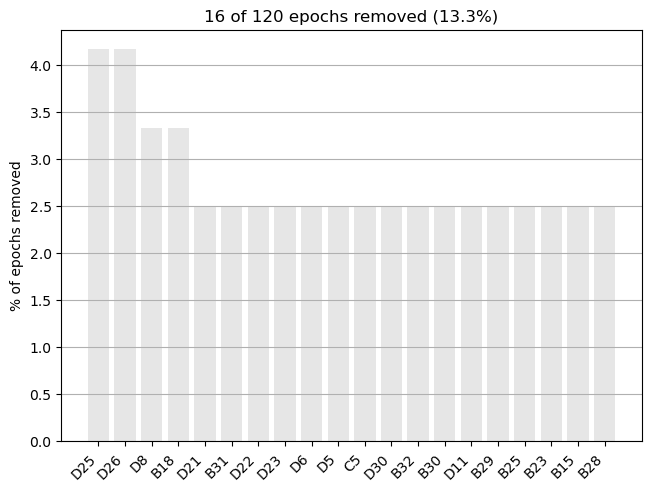

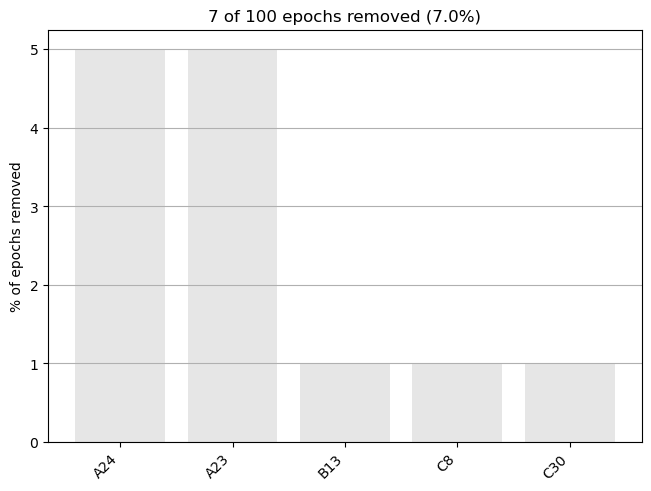

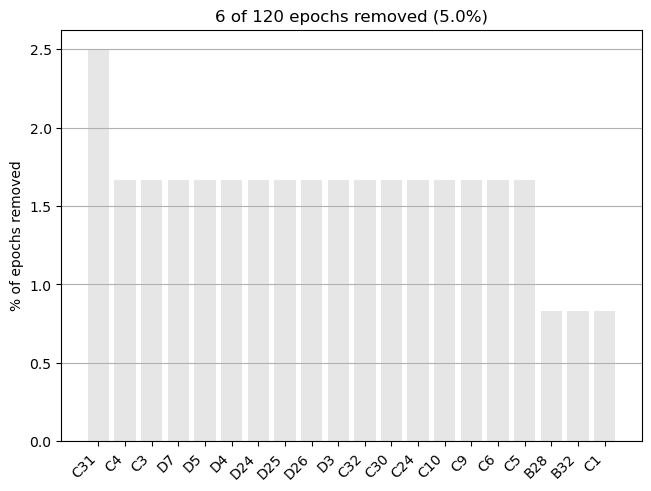

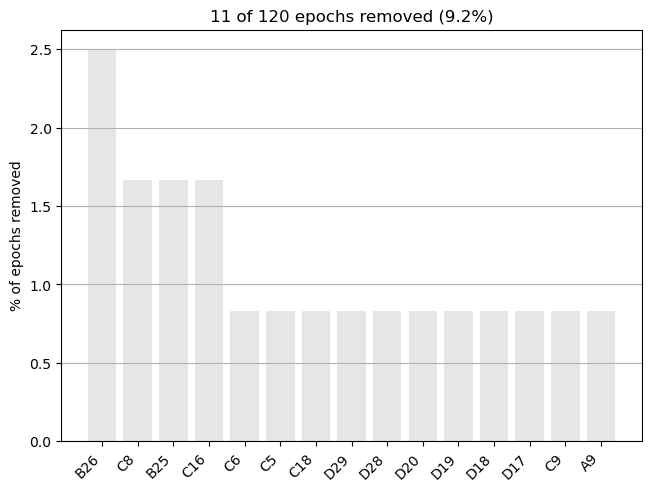

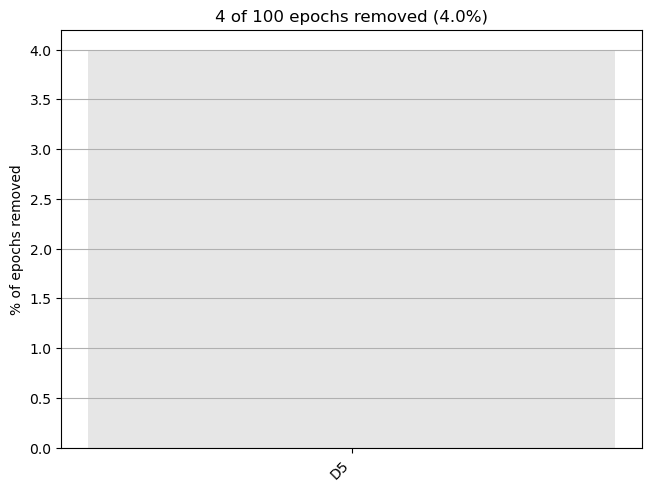

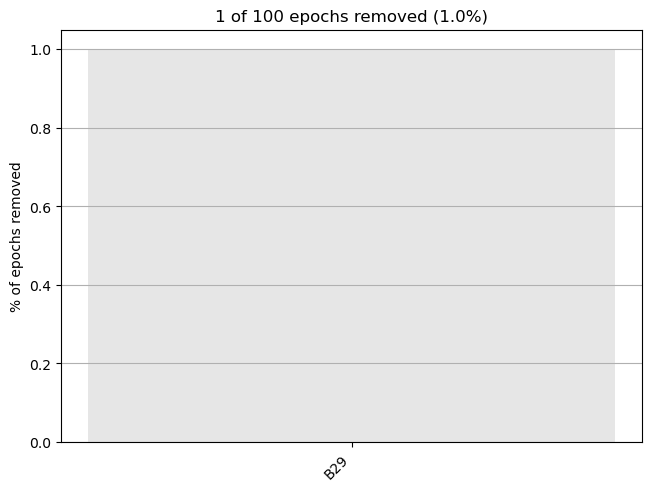

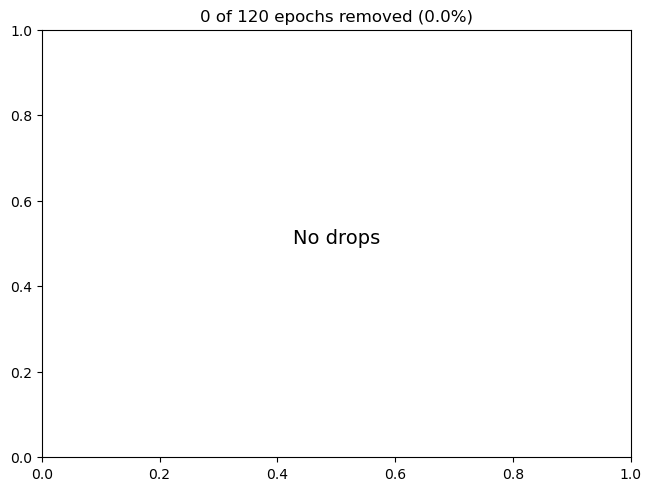

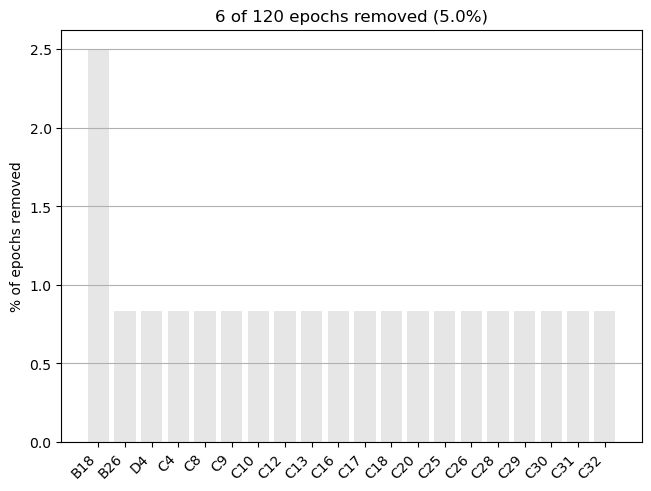

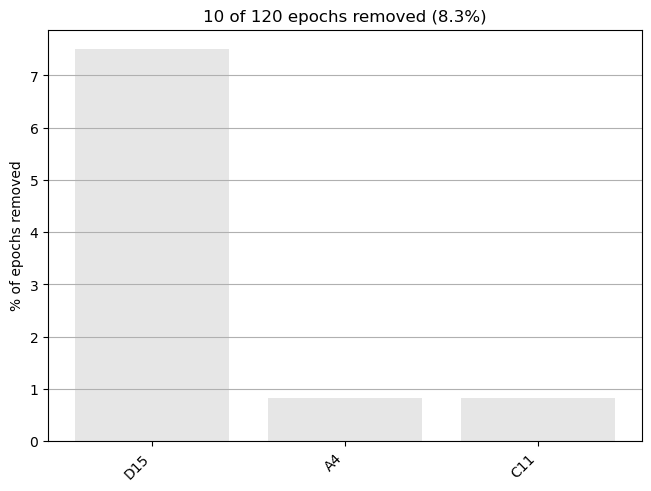

In [16]:
# Visualize the dropped epochs
for sub in participants_pronounced:
    sub.plot_drop_log()

#for sub in participants_inner:
#    sub.plot_drop_log()
    
#for sub in participants_visualized:
#    sub.plot_drop_log()

## 2.2 Artefact removal with Independent Component Analysis (ICA)
**(Has already been done by Nieto et al.)**

I have looked into ICA for sub-1 and I think everything looks great (eyeblinks etc. are removed).

## 2.3 Check channels and electrode locations

OBS: channel location (make_standard_montage etc) is already defined in the loop above, that loads in the data

Number of channels: 128
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32']


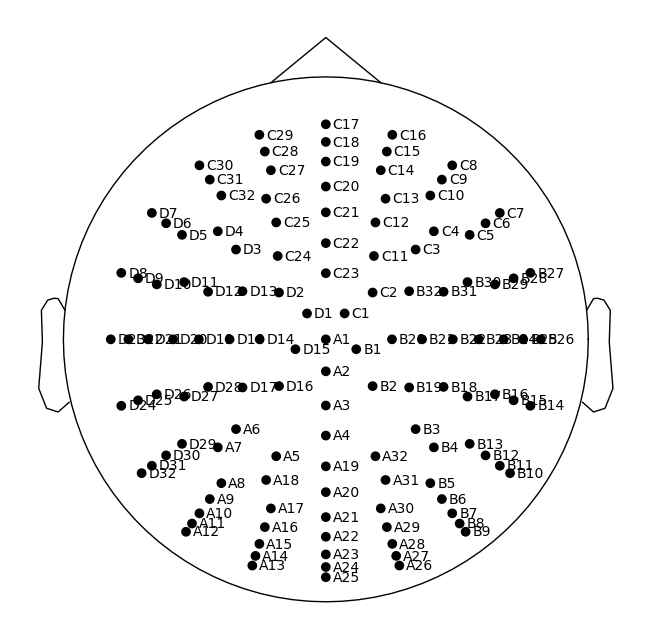

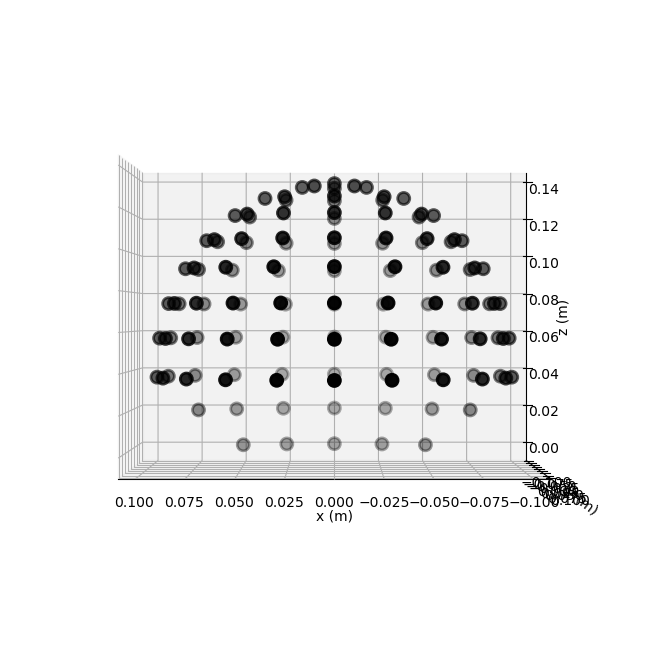

In [18]:
mne.channels.get_builtin_montages(descriptions=True) # Find type of montage ... here: BioSeimi128

print('Number of channels: ' + str(len(montage.ch_names)))
print(participants_pronounced[0].ch_names)

participants_pronounced[0].plot_sensors(ch_type='eeg', show_names=True); # show_names=True shows the channel names
participants_pronounced[0].plot_sensors("3d");

### 3 Event detection

All events has already been deteceted (Nieto) and grouped (Nieto, .dat file + matched by me, in the first loop)

In [19]:
print(participants_pronounced[0]['Arriba'].events[0:10]) 
print(participants_pronounced[0].events[30:40]) 

# Print first 10 events in the given condition and class
# [timestamp x condition x class]

[[ 94067      0     31]
 [120315      0     31]
 [147006      0     31]
 [199928      0     31]
 [206567      0     31]
 [220169      0     31]
 [239880      0     31]
 [246246      0     31]
 [279184      0     31]
 [298827      0     31]]
[[ 958193       0      32]
 [ 964866       0      32]
 [ 984902       0      32]
 [1077316       0      32]
 [1116841       0      32]
 [1179559       0      32]
 [1205653       0      32]
 [1225586       0      32]
 [1272553       0      32]
 [1279055       0      32]]


### 3.1 Time window for epochs

In [20]:
# Done by Nieto already - Time window for the epochs = 4.5 s length signals

# BUT as I only want to classify signal from the action interval (where the participant had to imagine or pronounce speech),
# I have to define the temporal epoch, which I will use as input for the classifier.

action_participants_pronounced = []
action_participants_inner = []
action_participants_visualized = []

action_tmin = 1
action_tmax = 3.5

for sub in participants_pronounced:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_pronounced.append(time_windowed_data)

for sub in participants_inner:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_inner.append(time_windowed_data)

for sub in participants_visualized:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_visualized.append(time_windowed_data)

## 3.2 Estimating evoked responses

### 3.2.1 Individual-level (From Epochs to Evoked):

In [22]:
evoked_pronounced = []
evoked_inner = []
evoked_visualized = []

modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']

for participant in action_participants_pronounced:
    evoked_p = {}
    for label in modality_label:
        evoked_p[label] = participant[label].average()
    evoked_pronounced.append(evoked_p)
    
for participant in action_participants_inner:
    evoked_i = {}
    for label in modality_label:
        evoked_i[label] = participant[label].average()
    evoked_inner.append(evoked_i)
    
for participant in action_participants_visualized:
    evoked_v = {}
    for label in modality_label:
        evoked_v[label] = participant[label].average()
    evoked_visualized.append(evoked_v)
    

combining channels using "gfp"
combining channels using "gfp"


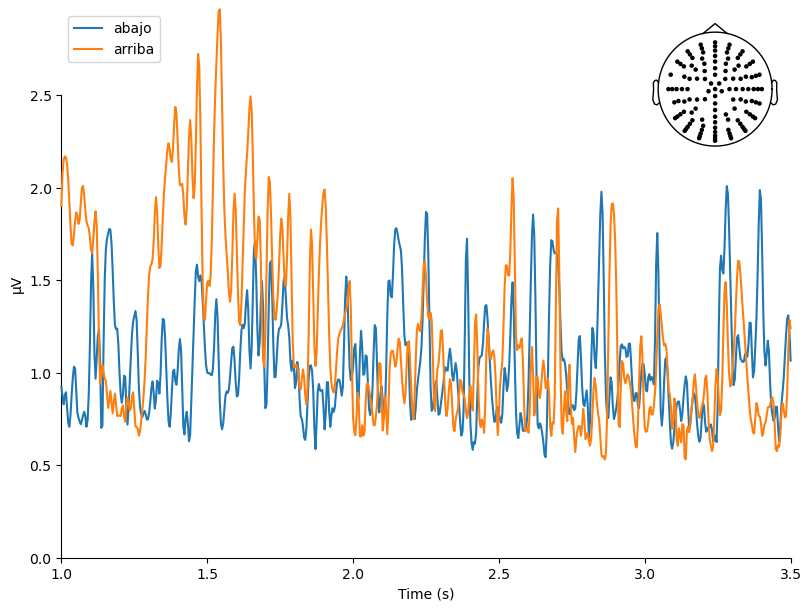

[<Figure size 800x600 with 2 Axes>]

In [23]:
mne.viz.plot_compare_evokeds(dict(abajo=evoked_inner[1]['Abajo'],arriba=evoked_inner[1]['Arriba']),
                             legend='upper left', show_sensors='upper right')

The plot shows an estimate of evoked responses to 'Abajo' and 'Arriba' by averaging together the epochs in each class for participant 2

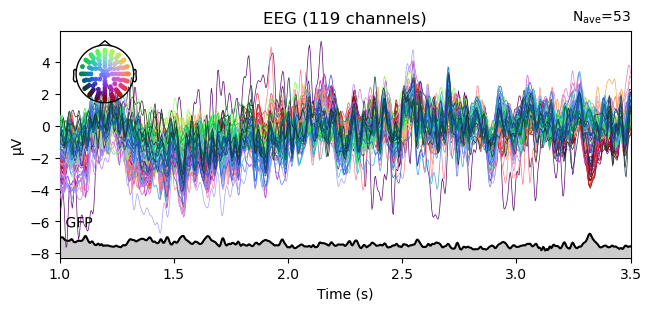

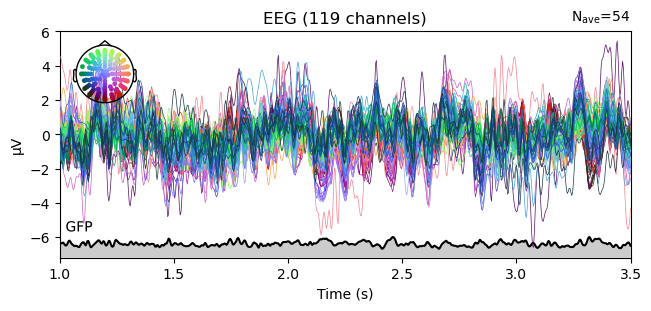

In [24]:
evoked_inner[1]['Arriba'].plot(gfp=True,spatial_colors= True);
evoked_inner[1]['Abajo'].plot(gfp=True,spatial_colors= True);

The grey in the bottom = global field power (gfp)

Gfp is a measure of agreement of the signals picked up by all sensors across the entire scalp --> if all sensors at a given timepoint have the same values, the gfp will equal 0 at that timepoint.

### 3.2.2 Group-level (aka grand_average):

In [ ]:
modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']
grand_average_pronounced = {}
grand_average_inner = {}
grand_average_visualized = {}

for label in modality_label:
    grand_average_pronounced[label] = mne.grand_average([evo[label] for evo in evoked_pronounced])
    grand_average_inner[label] = mne.grand_average([evo[label] for evo in evoked_inner])
    grand_average_visualized[label] = mne.grand_average([evo[label] for evo in evoked_visualized])

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


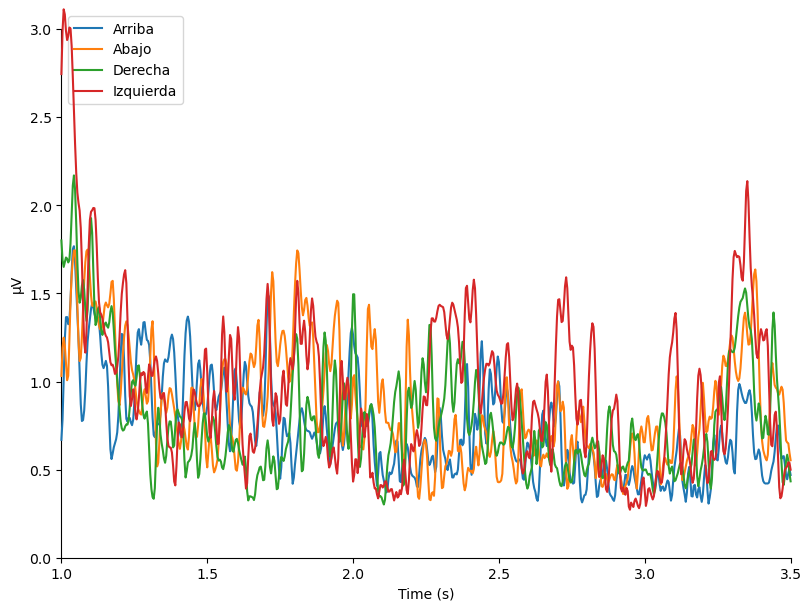

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


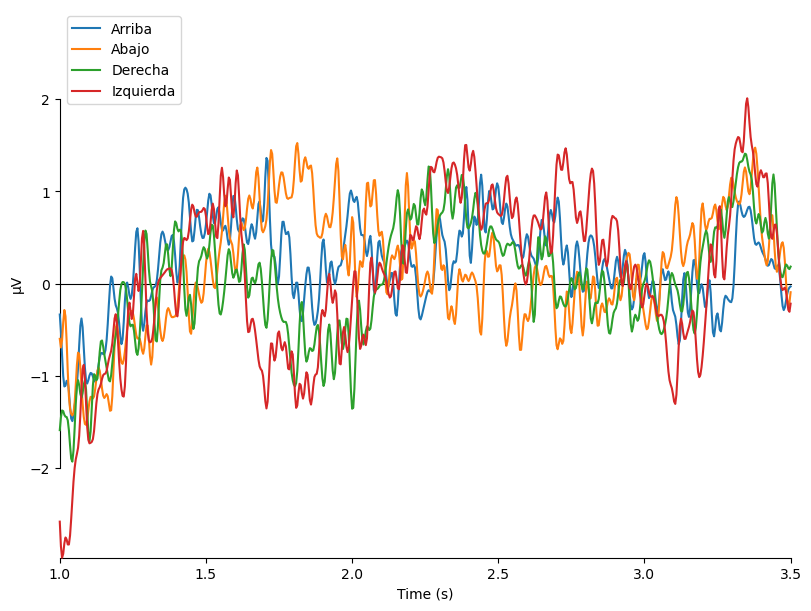

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


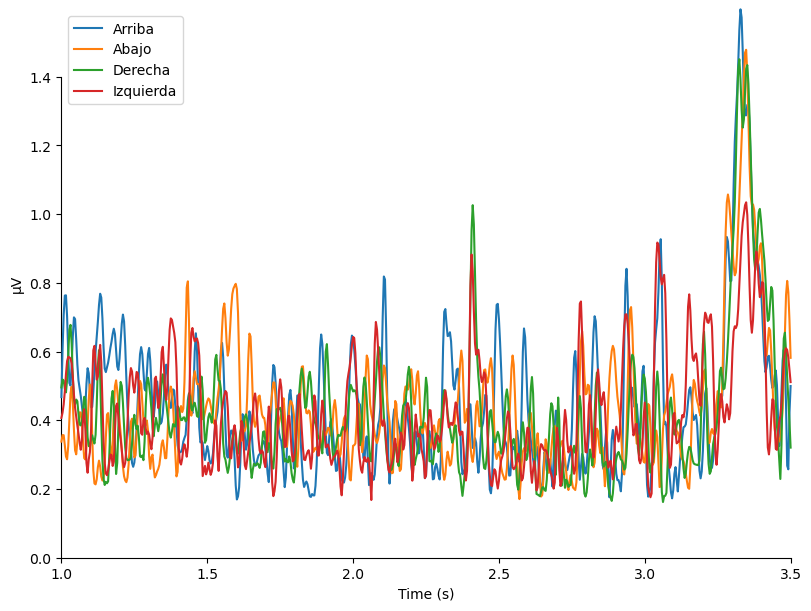

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


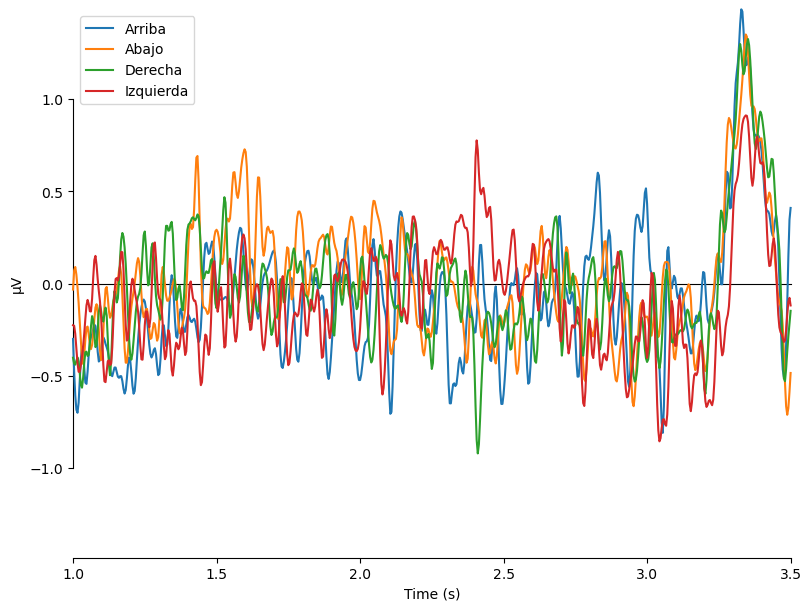

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


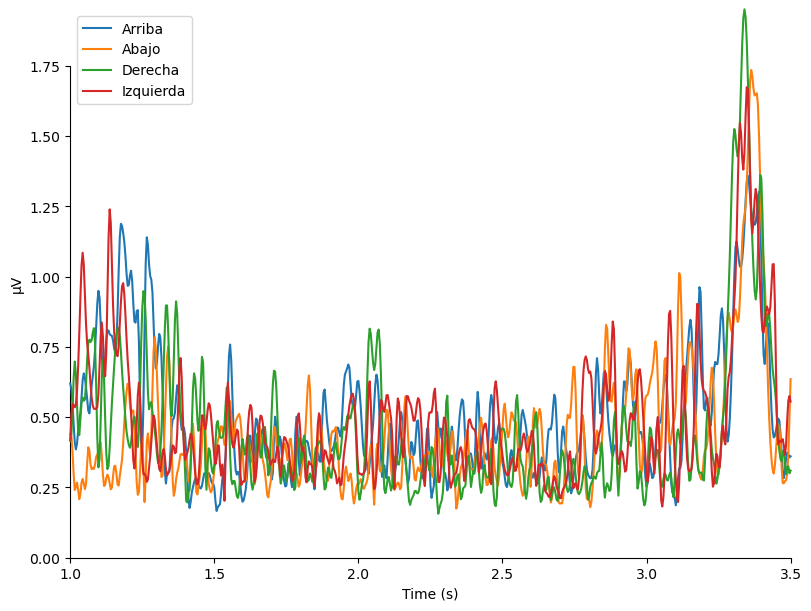

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


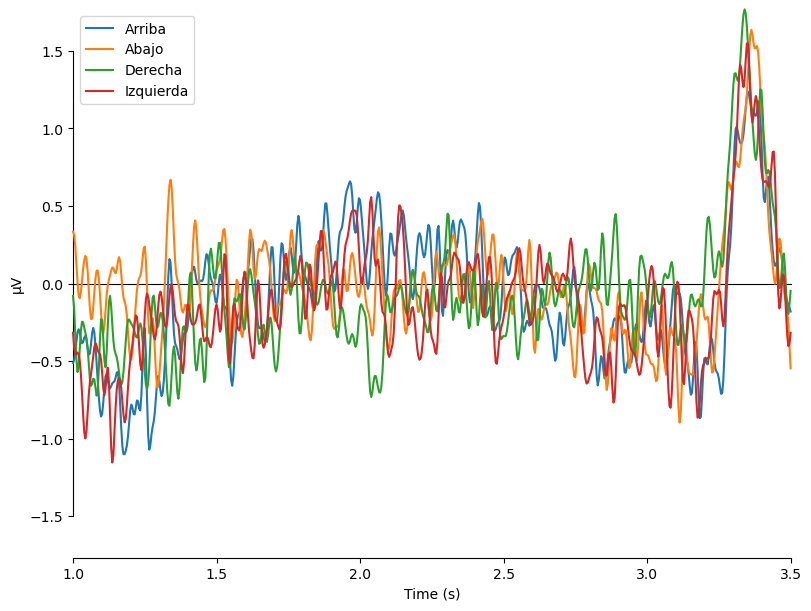

[<Figure size 800x600 with 1 Axes>]

In [26]:
mne.viz.plot_compare_evokeds(grand_average_pronounced, combine='gfp') # global field power
mne.viz.plot_compare_evokeds(grand_average_pronounced, combine='mean')

mne.viz.plot_compare_evokeds(grand_average_inner, combine='gfp')
mne.viz.plot_compare_evokeds(grand_average_inner, combine='mean')

mne.viz.plot_compare_evokeds(grand_average_visualized, combine='gfp')
mne.viz.plot_compare_evokeds(grand_average_visualized, combine='mean')

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


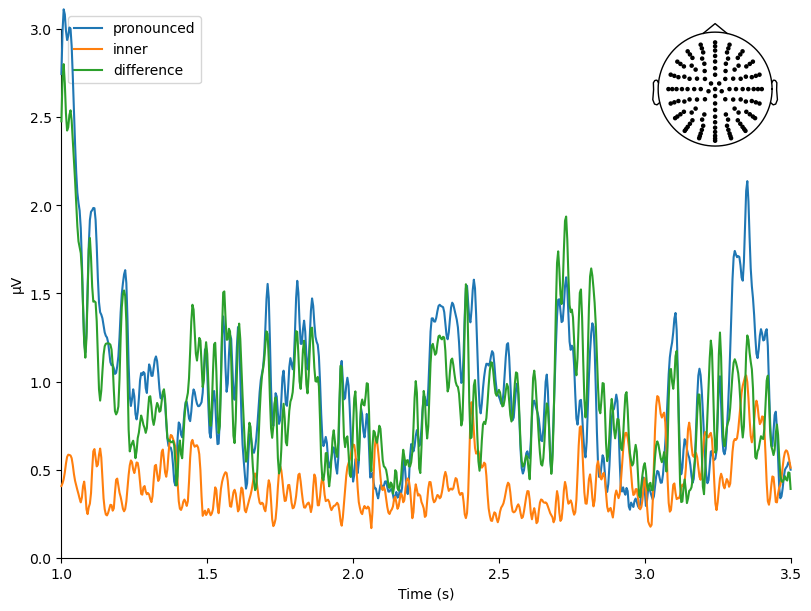

combining channels using "gfp"


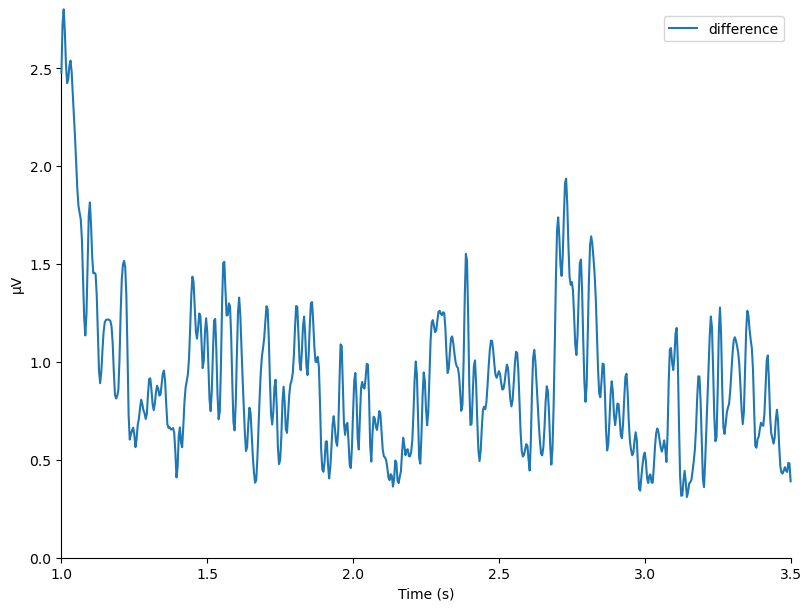

[<Figure size 800x600 with 1 Axes>]

In [27]:
# Creating a difference wave between the grand_average of the two condition: inner and pronounced
difference_pronounced_inner = mne.combine_evoked([grand_average_pronounced[label], grand_average_inner[label]], weights=[1, -1])

mne.viz.plot_compare_evokeds(dict(pronounced=grand_average_pronounced[label], inner=grand_average_inner[label],
                                  difference=difference_pronounced_inner), legend='upper left', show_sensors='upper right')

mne.viz.plot_compare_evokeds(dict(difference = difference_pronounced_inner), legend = 'upper right')

## 3.6 Topographies
Topographies display the EEG voltage values at each channel on the scalp. 
Different voltage ranges are represented with different colors and it allow us to inspect at once the distribution of voltage values on the scalp.

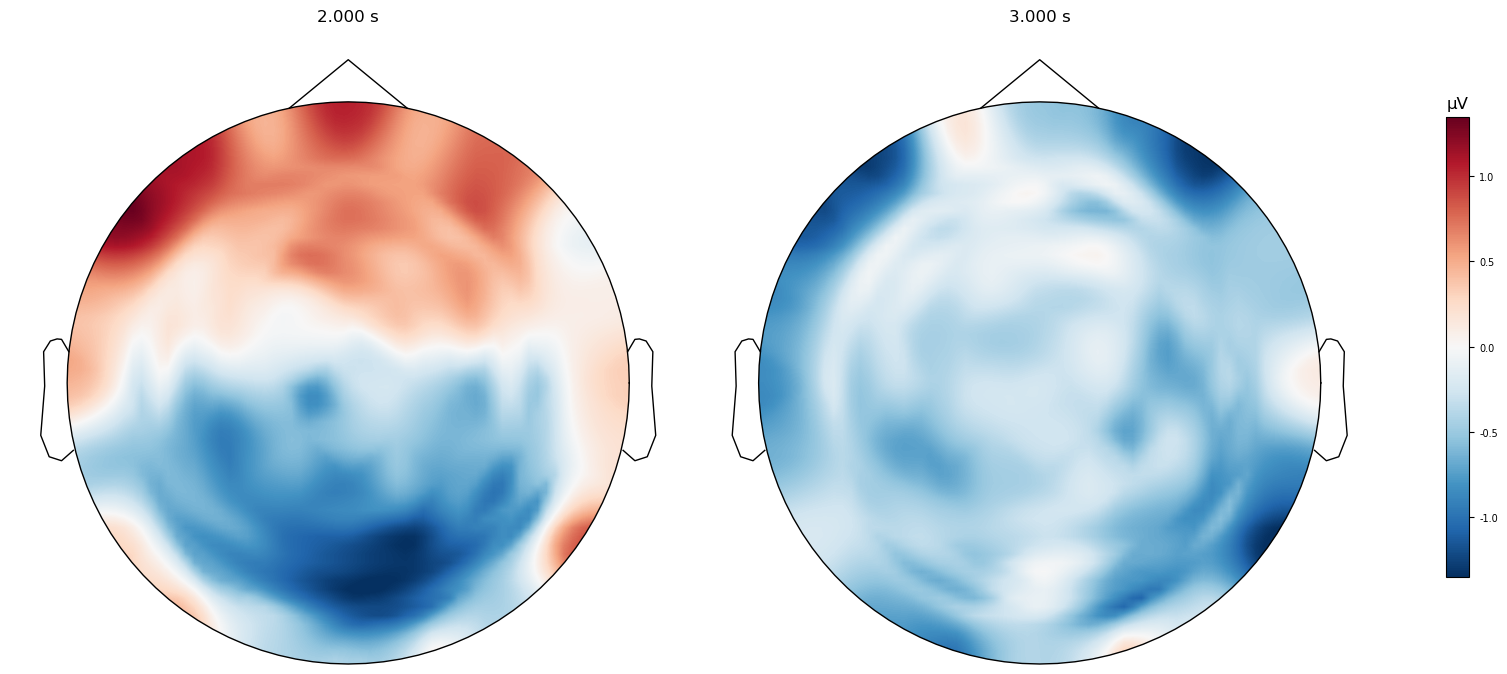

In [28]:
# define timepoints at every 50 ms in the epoc
time_points =np.arange(2, 3.3)

#grand_average_pronounced[label].plot_joint(picks='eeg')
#grand_average_pronounced[label].plot_topomap(times=time_points, ch_type='eeg');

#grand_average_inner[label].plot_joint(picks='eeg')
grand_average_inner[label].plot_topomap(times=time_points, ch_type='eeg', size=5, sensors=False, contours=False);

#grand_average_visualized[label].plot_joint(picks='eeg')
#grand_average_visualized[label].plot_topomap(times=time_points, ch_type='eeg');

#difference_pronounced_inner.plot_topomap(time_points, sensors=False, size=5);


In [ ]:
# Zooming in on 100 ms to see the EEG channels for the conditions
grand_average_pronounced[label].plot_topomap(1, ch_type='eeg', show_names=True, colorbar=False, size=5, res=128, time_unit='s');
grand_average_inner[label].plot_topomap(1, ch_type='eeg', show_names=True, colorbar=False, size=5, res=128, time_unit='s');
grand_average_visualized[label].plot_topomap(1, ch_type='eeg', show_names=True, colorbar=False, size=5, res=128, time_unit='s');

## 3.4 Channel selection

In [ ]:
# BA2: left hemisphere - 39 channels

left_participant_pronounced = []
left_participant_inner = []

for participant_pronounced, participant_inner in zip(action_participants_pronounced, action_participants_inner):
    # Subset: Left Hemisphere
    subset_left_hemisphere = ['C29', 'C28', 'C26', 'C24', 'C31', 'C32', 'D7', 'D5', 'D3', 'D13', 'D11', 'D23', 'D21', 'D19', 'D14',
                              'D24', 'D26', 'D28', 'D16', 'D31', 'D29', 'A6', 'A12', 'A10', 'A8', 'A14', 'A16', 'A18', 'C17', 'C19',
                              'C21', 'C23', 'A1', 'A3', 'A19', 'A21', 'A23', 'A25', 'D9']

    left_p_ch_names = [x for x in participant_pronounced.ch_names if x in subset_left_hemisphere]
    left_i_ch_names = [x for x in participant_inner.ch_names if x in subset_left_hemisphere]

    left_sub_pron = participant_pronounced.copy().pick_channels(left_p_ch_names)
    left_sub_inner = participant_inner.copy().pick_channels(left_i_ch_names)

    left_participant_pronounced.append(left_sub_pron) 
    left_participant_inner.append(left_sub_inner)

# BA3: Broca's and Wernicke's areas - 39 channels   
    
bw_participant_pronounced = []
bw_participant_inner = []

for participant_pronounced, participant_inner in zip(action_participants_pronounced, action_participants_inner):
    # Subset: Broca-Wernicke
    subset_broca_wernicke = ['D7', 'D6', 'D5', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D23', 'D22', 'D21', 'D20',
                             'D19', 'D18', 'D14', 'D15', 'D24', 'D25','D26', 'D27', 'D28', 'D17', 'D16', 'D32', 'D31', 'D30', 'D29', 'A1']

    bw_pronounced_ch_names = [x for x in participant_pronounced.ch_names if x in subset_broca_wernicke]
    bw_inner_ch_names = [x for x in participant_inner.ch_names if x in subset_broca_wernicke]

    bw_sub_pronounced = participant_pronounced.copy().pick_channels(bw_pronounced_ch_names)
    bw_sub_inner = participant_inner.copy().pick_channels(bw_inner_ch_names)

    bw_participant_pronounced.append(bw_sub_pronounced)
    bw_participant_inner.append(bw_sub_inner)